
1、先提取出每个地区的数据，再将每个地区的数据按照每天产品需求量去处理(df101\df102\....)

2、每个地区的数据进行分析处理，查看价格分布分箱操作、编码转换、分解出是否是工作日或周末、日期是周几、等操作


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes
from pandas.plotting import autocorrelation_plot as auto_corr

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

#For date-time
import math
from datetime import datetime
from datetime import timedelta

# # Another imports if needs
# import itertools
# import statsmodels.api as sm
# import statsmodels.tsa.api as smt
# import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
# from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing

# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# from statsmodels.tsa.stattools import adfuller, acf, pacf
# from statsmodels.tsa.arima_model import ARIMA
# !pip install pmdarima
# from pmdarima.utils import decomposed_plot
# from pmdarima.arima import decompose
# from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")

In [13]:
import pandas as pd 
import numpy as np 
df = pd.read_csv('process1.csv',encoding='utf-8')
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量
0,2015-09-01,104,22069,307,403,offline,1114.0,19
1,2015-09-01,104,20028,301,405,offline,1012.0,12
2,2015-09-02,104,21183,307,403,online,428.0,109
3,2015-09-02,104,20448,308,404,online,962.0,3
4,2015-09-02,104,21565,307,403,offline,1400.0,3
...,...,...,...,...,...,...,...,...
597689,2018-12-20,102,20994,302,408,offline,843.0,59
597690,2018-12-20,102,21875,302,408,offline,762.0,502
597691,2018-12-20,102,20215,302,408,offline,2013.0,106
597692,2018-12-20,102,20195,302,408,offline,2120.0,187


In [14]:
# plt.rcParams['font.sans-serif'] = ['SimHei']
# # 选择需要分析的特征列和订单需求量列
# target_col = '订单需求量'
# feature_cols = [col for col in df.columns if col != target_col]

# # 计算相关系数
# corr = df[feature_cols + [target_col]].corr()

# # 绘制热力图
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr, annot=True, cmap='coolwarm')
# plt.title('热力图')
# plt.show()

# 建模准备，数据分析+数据准备

## 以地区101为例，制作出101地区的建模数据准备

In [15]:
set(df['销售区域编码'])

{101, 102, 103, 104, 105}

In [16]:
df_101 = df.loc[df['销售区域编码']==104]
df_101


plt.figure(figsize=(16,8))
plt.rcParams['font.sans-serif']='simhei'
plt.rcParams['axes.unicode_minus']=False
sns.lineplot(x='grade', y='订单需求量', data=df_101)
plt.show()
# len(set(df_101['产品编码']))

仅仅将价格划分为四个区间是不够的，下面我们对价格进行最优分箱操作，再将价格区间进行对应编码处理

### 重新对价格进行更细致的分箱编码

In [17]:
max(df_101['产品价格'])

3002.0

In [18]:
from scipy.stats import stats
def optimal_bins(Y,X,n):
    """
    :Y  目标变量
    ：X  待分箱特征
    ：n 分箱数初始值
    return : 统计值，分箱边界值列表、woe值、iv值
    """
    r = 0  #xia相关系数的初始值
    total_bad = Y.sum()  #总的坏样本数
    total_good = Y.count() - total_bad   #总的好样本数
    #分箱过程
    while np.abs(r) <1:   #相关系数的绝对值等于1结束循环，循环目的找寻最好正反相关性
        #df1中的bin为给X分箱对应的结果
        df1 = pd.DataFrame({'X':X,'Y':Y,'bin':pd.qcut(X,n,duplicates='drop')})  #drop表示删除重复元素
        #将df1基于箱子进行分组
        df2 = df1.groupby('bin')
        #r返回的是df1对箱子分组后，每组数据X的均值的相关系数，如果系数不为正负1，则减少分箱的箱数
        r,p = stats.spearmanr(df2.mean().X,df2.mean().Y) #计算相关系数
        n = n-1
    cut =[0]  #分箱边界值列表
    for i in range(1,n+2):  #i的取值范围是1->（n+1），n+1是分箱的数量
        qua = X.quantile(i/(n+1)) #quantile把给定的乱序的数值有小到大并列分成n等份，参数表述取出第百分之多少大小的数值
                                    #i的取值范围是1->n 1/n.2/n 3/n...n/n
        cut.append(round(qua,6))
   
    return cut

In [19]:
#对RevolvingRatio列进行分箱操作：
cut_bins = optimal_bins(df_101.订单需求量,df_101.产品价格,n=10)
cut_bins

[0, 433.0, 723.0, 1057.0, 3002.0]

In [20]:

df_101['价格区间'] = pd.cut(df_101['产品价格'],cut_bins,labels=[x for x in range(len(cut_bins)-1)])
df_101

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量,价格区间
0,2015-09-01,104,22069,307,403,offline,1114.0,19,3
1,2015-09-01,104,20028,301,405,offline,1012.0,12,2
2,2015-09-02,104,21183,307,403,online,428.0,109,0
3,2015-09-02,104,20448,308,404,online,962.0,3,2
4,2015-09-02,104,21565,307,403,offline,1400.0,3,3
...,...,...,...,...,...,...,...,...,...
178615,2016-12-31,104,21551,308,404,online,1427.0,8,3
178616,2016-12-31,104,21179,308,404,online,1226.0,7,3
178617,2016-12-31,104,20340,308,404,online,1227.0,5,3
178618,2016-12-31,104,21446,308,404,online,1531.0,67,3


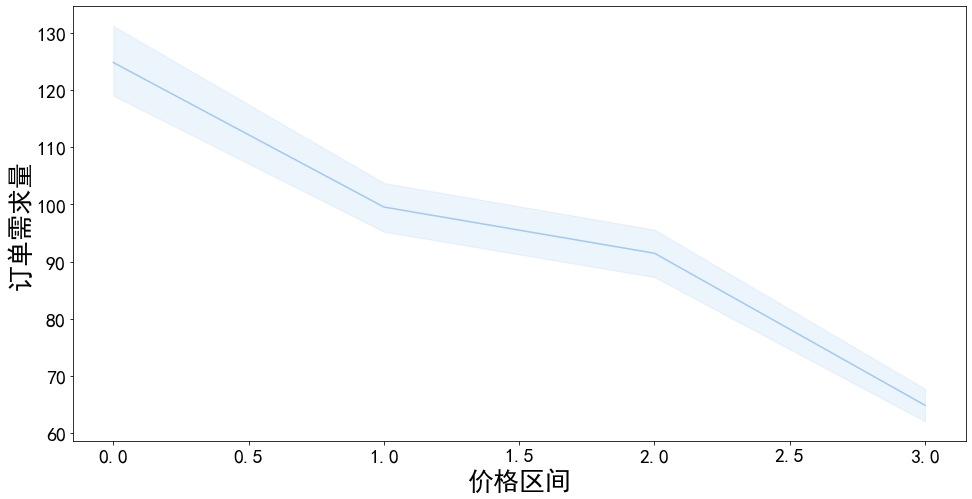

In [21]:
# 设置调色板
palette = sns.color_palette('pastel', 10)

plt.figure(figsize=(16,8))
plt.rcParams['font.sans-serif']='simhei'
plt.rcParams['axes.unicode_minus']=False
sns.lineplot(x='价格区间', y='订单需求量', data=df_101,color =palette[0])
# 设置x轴标签的字体大小
plt.xlabel('价格区间', fontsize=26)
plt.ylabel('订单需求量',fontsize=26)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('1.jpg',dpi=200)
plt.show()

这样可以更细致的对价格进行分区间，有利于建模时，价格区间对模型的影响

### 利用map映射对“渠道”和“月头、月中..”编码处理

In [22]:
dict_qudao = {'offline':0,'online':1}
dict_moth = {'月初':0,'月中':1,'月末':2}
df_101.销售渠道名称 = df_101.销售渠道名称.map(dict_qudao)
df_101['每月时间段'] =df_101.标签.map(dict_moth)
df_101

AttributeError: 'DataFrame' object has no attribute '标签'

### 根据第一问分析，需要对每个地区季节再进行分类和标签编码

第一问分析可知，季节对需求量有一定的影响，所以需要对每个地区的季节进行分离和编码

In [ ]:
df_101["season"] = df_101["Month"].map({3:"春季",4:"春季",5:"春季",6:"夏季",7:"夏季",
                                        8:"夏季",9:"秋季",10:"秋季",11:"秋季",12:"冬季",1:"冬季",2:"冬季"})
df_101
dict_season = {'春季':0,'夏季':1,'秋季':2,'冬季':3}
df_101['season_bm'] =df_101.season.map(dict_season)
df_101

### 构造新特征，日期为每周星期几、工作日还是休息日

由于原数据中的week为当前日期，为一年的第几周，这样的特征列在模型训练以及预测都意义不大，

所以我们重新分离出当前日期是星期几、以及是否是工作日、休息日、（节假日已经构造了）

In [ ]:
import datetime
df_101['订单日期'] = pd.to_datetime(df_101['订单日期'])  #对日期列进行日期格式转换
df_101['星期几'] = df_101.订单日期.dt.weekday   #0-6  {0, 1, 2, 3, 4, 5, 6}  星期一对应0.。。
df_101

# set(df_101['星期几'])

In [ ]:
from chinese_calendar import is_workday

df_101['is_workday']=df_101['订单日期'].map(lambda x:is_workday(x))
df_101

In [ ]:
dict_is_workday = {False:0,True:1}
df_101['is_workday'] =df_101.is_workday.map(dict_is_workday)
df_101

### 删除无用列，整理df

由于最终目标是预测2019 年 1 月、2 月、3 月，所以在不适用LSTM模型时，不需要“年”列，使用常规的机器学习模型时，可以试着将月、日放入型

所以删除“订单日期”，“Year”列，以及其它无用列

In [ ]:
df_101.drop(['产品价格','grade','标签','season','销售区域编码'],axis=1,inplace=True)
df_101

数据先暂时处理成这样，因为最终目标预测2019 年 1 月、2 月、3 月时，可以根据给出的待预测数据，推导出这些列特征方便于机器学习回归模型的

训练和预测

### 数据再探索

In [ ]:
#查看各特征列有多少种：

print("产品编码:",df_101['产品编码'].nunique() )
print("产品大类编码:",df_101['产品大类编码'].nunique() )
print("产品细类编码:",df_101['产品细类编码'].nunique() )

In [ ]:
store_dept_table = pd.pivot_table(df_101, index='产品大类编码', columns='产品细类编码',
                                  values='订单需求量', aggfunc=np.mean)
display(store_dept_table)

In [ ]:
store_dept_table = pd.pivot_table(df_101, index='产品细类编码', columns='产品编码',
                                  values='订单需求量', aggfunc=np.mean)
display(store_dept_table)

In [ ]:
sns.barplot(x='是否节假日', y='订单需求量', data=df_101)

In [ ]:
sns.barplot(x='销售渠道名称', y='订单需求量', data=df_101)

In [ ]:
x = df_101['产品细类编码']
y = df_101['订单需求量']
plt.figure(figsize=(15,5))
plt.title('订单需求量 by 产品细类编码')
plt.xlabel('产品细类编码')
plt.ylabel('订单需求量')
plt.scatter(x,y)
plt.show()

In [ ]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='产品细类编码', y='订单需求量', data=df_101)

In [ ]:
df_101.groupby('Month')['订单需求量'].mean() # to see the best months for sales

In [ ]:
df_101.groupby('Year')['订单需求量'].mean() # to see the best years for sales

In [ ]:
monthly_sales = pd.pivot_table(df_101, values = "订单需求量", columns = "Year", index = "Month")
monthly_sales.plot()

In [ ]:
fig = sns.barplot(x='Month', y='订单需求量', data=df_101)

In [ ]:
df_101.groupby('week')['订单需求量'].mean().sort_values(ascending=False).head()

In [ ]:
weekly_sales = pd.pivot_table(df_101, values = "订单需求量", columns = "Year", index = "week")
weekly_sales.plot()

In [ ]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='week', y='订单需求量', data=df_101)

In [ ]:
plt.figure(figsize = (12,10))
sns.heatmap(df_101.corr().abs())    # To see the correlations
plt.show()

In [ ]:
drop_col = ['week','每月时间段','星期几','is_workday']
df_101.drop(drop_col, axis=1, inplace=True) # dropping columns
plt.figure(figsize = (12,10))
sns.heatmap(df_101.corr().abs())    # To see the correlations without dropping columns
plt.show()

In [ ]:
df_new = df_101.sort_values(by='订单日期', ascending=True) # sorting according to date
df_new

In [ ]:
train_data = df_new[:int(0.7*(len(df_new)))] # taking train part
test_data = df_new[int(0.7*(len(df_new))):] # taking test part

target = "订单需求量"
used_cols = [c for c in df_new.columns.to_list() if c not in [target]] # all columns except weekly sales

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

In [ ]:
X = df_new[used_cols] # to keep train and test X values together
X_train = X_train.drop(['订单日期'], axis=1) # dropping date from train
X_test = X_test.drop(['订单日期'], axis=1) # dropping date from test

In [ ]:
def wmae_test(test, pred): # WMAE for test 
    weights = X_test['是否节假日'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()



#making pipe tp use scaler and regressor together
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train, y_train)

# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)

In [ ]:
wmae_test(y_test, y_pred_test)

In [ ]:
x_axis=np.linspace(1,len(y_pred_test),len(y_pred_test))

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(x_axis[0:200],y_test[0:200],marker='.')
plt.plot(x_axis[0:200],y_pred_test[0:200],'r')
plt.legend(['true','prediction'])
plt.show()

In [ ]:
bestP = {'colsample_bytree': 0.8, 'learning_rate': 0.4, 'max_depth': 5.0, 'min_child_weight': 400.0, 'n_estimators': 1000.0, 'num_leaves': 25.0, 'subsample': 0.6000000000000001}

In [ ]:
import lightgbm

model = lightgbm.LGBMRegressor(
        n_estimators = int(bestP['n_estimators']),
        learning_rate = bestP['learning_rate'],
        subsample = bestP['subsample'],
        colsample_bytree = bestP['colsample_bytree'],
        max_depth = int(bestP['max_depth']),
        num_leaves = int(bestP['num_leaves']),
        min_child_weight = int(bestP['min_child_weight']))

# print('Prediction for Store: {}**'.format(d_store_id[store]))
model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_test,y_test)], eval_metric='rmse', verbose=1, early_stopping_rounds=20)
# validation_prediction[X_valid.index] = model.predict(X_test)
# eval_prediction[X_test.index] = model.predict(X_test)

In [ ]:
pre = model.predict(X_test)


In [ ]:
x_axis=np.linspace(1,len(pre),len(pre))
plt.plot(x_axis[:100],y_test[:100])
plt.plot(x_axis[:100],pre[:100])
plt.legend(['true','prediction'])
plt.show()

In [ ]:
wmae_test(y_test, pre)

调参优化

In [ ]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'learning_rate': .1,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'subsample': .8,
    'subsample_freq': 1,
    'colsample_bytree': .8,
    'reg_alpha':0.2 ,
    'reg_lambda':0.2 ,
    'n_estimators': 200
}
# ```

# 在调参过程中，一般是先固定一些参数，然后逐一调试某一个参数的取值，记录下模型的拟合效果，以找到最优的参数组合。通常调参的参数主要包括：

# - `learning_rate`：学习率，用于减小每次迭代的步长，缓解过拟合，建议取值在.05~.1之间
# - `num_leaves`：决策树的叶子节点数，过大容易过拟合，过小可能造成欠拟合，建议取值在20~50之间
# - `max_depth`：决策树的深度，可以控制一棵树的复杂度，过深容易过拟合，建议取值不超过10
# - `min_child_samples`：叶子节点最少包含几个样本，容易过拟合，建议取值在20~100之间
# - `subsample`：随机抽取部分数据样本进行决策树的训练，取值过大会导致过拟合，建议取值在.5~.8之间
# - `colsample_bytree`：随机抽取部分特征进行决策树的训练，与subsample的作用类似，可以防止过拟合，建议取值在.5~.8之间
# - `reg_alpha`：L1正则化，用于防止过拟合，建议取值在~1之间
# - `reg_lambda`：L2正则化，用于防止过拟合，建议取值在~1之间
# - `n_estimators`：迭代次数，建议取值不低于100

# 下面是一个简单的参数调优示例：

# ```python
from sklearn.model_selection import GridSearchCV


# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': 'mse',
#     'subsample': 1,
#     'n_estimators': 200
# }

param_grid = {
    'learning_rate': [.01, .1, .25, 1],
    'num_leaves': [10, 20, 30, 50, 100],
    'max_depth': [3, 5, 7, 9],
    'min_child_samples': [20, 50, 100]
}

# 使用网格搜索寻找最佳参数
grid_search = GridSearchCV(estimator=lgb.LGBMRegressor(**params),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

# 输出最佳参数组合和最小的平均方差
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", np.sqrt(np.abs(grid_search.best_score_)))
# ```

# 最后，用得到的最优参数来训练LGBMRegressor模型并进行预测：

# ```python
# 使用最优参数组合训练模型


In [ ]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'learning_rate': 0.01,
    'num_leaves': 50,
    'max_depth': 7,
    'min_child_samples': 100,
    'subsample': .8,
    'colsample_bytree': .8,
    'reg_alpha':0.2 ,
    'reg_lambda': 0.2,
    'n_estimators': 200
}

# 训练模型
lgb_model = lgb.LGBMRegressor(**params)
lgb_model.fit(X_train, y_train)

# 预测测试集
y_pred = lgb_model.predict(X_test)

# 计算均方根误差（RMSE）
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: ", rmse)


In [ ]:
x_axis=np.linspace(1,len(y_pred),len(y_pred))
plt.plot(x_axis[:100],y_test[:100])
plt.plot(x_axis[:100],y_pred[:100])
plt.legend(['true','prediction'])
plt.show()

In [ ]:
wmae_test(y_test, y_pred)

上诉经过了随机森林、LGBM模型发现效果不是很好，总结有可能是因为，产品编码、大类编码、细类编码为数值形式，导致影响模型

## 重新对数据进行编码矩阵处理

In [ ]:
df_new = df_101.sort_values(by='订单日期', ascending=True) # sorting according to date
df_new

In [ ]:
temp = df_new[['产品编码','产品大类编码','产品细类编码']]



temp["产品编码"]=temp["产品编码"].apply(str)
temp["产品大类编码"]=temp["产品大类编码"].apply(str)
temp["产品细类编码"]=temp["产品细类编码"].apply(str)

temp.info()
temp = pd.get_dummies(temp)

In [ ]:
# df_new =pd.merge(df_new,temp,on='订单日期')
# df_new

df1 = pd.concat([df_new,temp], axis=1)
df1.drop(['产品编码','产品大类编码','产品细类编码'],axis=1,inplace=True)
df1

In [ ]:
train_data1 = df1[:int(0.7*(len(df_new)))] # taking train part
test_data1 = df1[int(0.7*(len(df_new))):] # taking test part

target = "订单需求量"
used_cols = [c for c in df1.columns.to_list() if c not in [target]] # all columns except weekly sales

X_train1 = train_data1[used_cols]
X_test1 = test_data1[used_cols]
y_train1 = train_data1[target]
y_test1 = test_data1[target]

X1 = df1[used_cols] # to keep train and test X values together
X_train1 = X_train1.drop(['订单日期'], axis=1) # dropping date from train
X_test1 = X_test1.drop(['订单日期'], axis=1) # dropping date from test

In [ ]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'learning_rate': 0.01,
    'num_leaves': 50,
    'max_depth': 7,
    'min_child_samples': 100,
    'subsample': .8,
    'colsample_bytree': .8,
    'reg_alpha':0.2 ,
    'reg_lambda': 0.2,
    'n_estimators': 200
}

# 训练模型
lgb_model = lgb.LGBMRegressor(**params)
lgb_model.fit(X_train1, y_train1)

# 预测测试集
y_pred1 = lgb_model.predict(X_test1)

# 计算均方根误差（RMSE）
rmse = np.sqrt(mean_squared_error(y_test1, y_pred1))
print("Root Mean Squared Error: ", rmse)

In [ ]:
x_axis=np.linspace(1,len(y_pred1),len(y_pred1))
plt.plot(x_axis[:200],y_test1[:200],marker = '.')
plt.plot(x_axis[:200],y_pred1[:200],'r')
plt.legend(['true','prediction'])
plt.show()